## Exploration

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")



In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

def map_sentiment_to_score(sentiment_scores):
    compound_score = sentiment_scores['compound']
    predicted_score = (compound_score + 1) * 2.5  # Scale to a 0-5 score range
    return predicted_score

def predict_review_score(review_text):
    sentiment_scores = analyzer.polarity_scores(review_text)
    predicted_score = map_sentiment_to_score(sentiment_scores)
    return predicted_score


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\91960\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
import pandas as pd

def process(df):

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    
    df['CombinedText'] = df['Summary'] + ' ' + df['Text']

    df['CombinedText'] = df['CombinedText'].str.lower()
    df['CombinedText'] = df['CombinedText'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

    #df['CombinedText'].apply(lambda x : predict_review_score(x) if type(x)==str else 2.5)

    return df

In [4]:
trainingSet = pd.read_csv("./data/train.csv")

train_processed = process(trainingSet)

submissionSet = pd.read_csv("./data/test.csv")

testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')

testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

trainX =  train_processed[train_processed['Score'].notnull()]

testX = testX.drop(columns=['Text','Summary','ProductId','UserId','Time'])
trainX = trainX.drop(columns=['Text','Summary','ProductId','UserId','Time'])



In [5]:

testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)

In [44]:


X_train = pd.read_csv("./data/X_train.csv")
X_submission = pd.read_csv("./data/X_test.csv")


In [45]:
X_train['sentiment'] = X_train['CombinedText'].apply(lambda x : predict_review_score(x) if type(x)==str else 2.5)
X_submission['sentiment'] = X_submission['CombinedText'].apply(lambda x : predict_review_score(x) if type(x)==str else 2.5)
X_train.to_csv('sentiment_train.csv')
X_submission.to_csv('sentiment_test.csv')

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score','Id','CombinedText'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

X_train_processed = X_train
X_test_processed = X_test


Accuracy on testing set =  0.552582512838965
RMSE on testing set =  1.5809100127571882


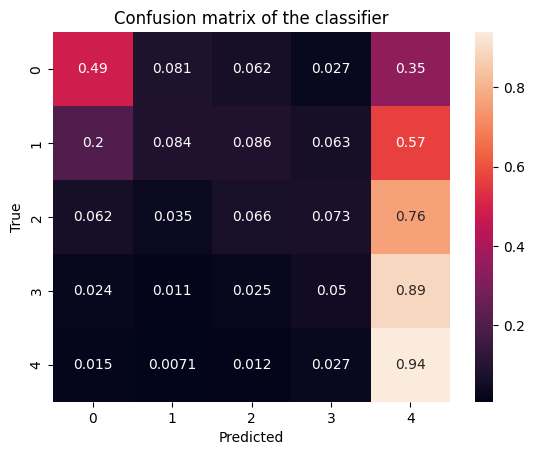

In [47]:
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#weights = {1:3, 2:3, 3:2, 4:1.5, 5:1}
#weights = [3.0,3.0,2.0,1.5,1.0]
#model = KNeighborsClassifier(n_neighbors=20,class_weight = weights).fit(X_train_processed, Y_train)
#model = RandomForestClassifier(class_weight = weights).fit(X_train_processed,Y_train)
#model = SVC(kernel='linear').fit(X_train_processed, Y_train)

model = xgb.XGBClassifier()
# Convert class labels to start from 0

model.fit(X_train_processed, Y_train-1)

# pickle model - saves it so you can load it later
with open('knn_20_model.obj', 'wb') as f:
        pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test-1, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test-1, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test-1, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Create the Kaggle submission

In [48]:
X_submission_processed = X_submission.drop(columns=['Score','Id','CombinedText'])
X_submission['Score'] = model.predict(X_submission_processed)


In [49]:
X_submission['Score'] = X_submission['Score']+1

In [50]:
sub = X_submission[['Id','Score']]
sub.to_csv('submission.csv',index=False)

Now you can upload the `submission.csv` to kaggle